# Neural Network Exercise

Now it's your turn to build a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebook though as you work through this.

First off, let's load the dataset through torchvision.

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

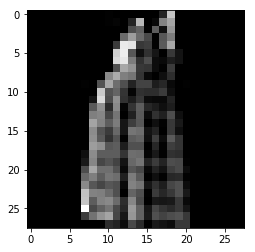

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

With the data loaded, it's time to import the necessary packages.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and softmax for the output to get the class probabilities.

In [7]:
class Network(nn.Sequential):
    def __init__(self, input_size, output_size, hidden_layers):
        super().__init__()
        # Input to a hidden layer
        self.fc1 = nn.Linear(input_size, hidden_layers[0])
        
        # Variable number of more hidden layers
        self.hidden_layers = [nn.Linear(h1, h2) for h1, h2 in zip(hidden_layers[:-1], hidden_layers[1:])]
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = F.relu(self.fc1(x))
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get 85-86% validation accuracy.

In [10]:
net

Network(
  (fc1): Linear(in_features=784, out_features=200)
  (output): Linear(in_features=200, out_features=10)
)

In [9]:
# Create the network, define the criterion and optimizer
net = Network(784, 10, [200])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
epochs = 2
steps = 0
running_loss = 0
print_every = 10
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                
                predicted = torch.exp(net.forward(inputs).data)
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0

NameError: name 'optimizer' is not defined

## Saving and loading networks

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions. 



In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    
    return ax